## Data Augmentation

In [1]:
import numpy as np
from connectomics.config import get_cfg_defaults
from connectomics.data.dataset import _get_input
from connectomics.data.augmentation import build_train_augmentor

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def show(image, cmap='gray', title='Test Title'):
    num_imgs = image.shape[0]
    fig = plt.figure(figsize=(20., 3.))
    fig.suptitle(title)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    image_list = np.split(image, num_imgs, 0)
    for ax, im in zip(grid, [np.squeeze(x) for x in image_list]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap=cmap)

    plt.show()
   
from yacs.config import CfgNode as CN
def remove_aug(cfg):
    # CfgNode is a subclass of Python dict
    for aug in cfg.AUGMENTOR:
        if isinstance(cfg.AUGMENTOR[aug], CN):
            if cfg.AUGMENTOR[aug]['ENABLED'] is not None:
                cfg.AUGMENTOR[aug]['ENABLED'] = False
    return cfg

In [3]:
# Load configs and dataset
cfg_filename = '../configs/SNEMI-Neuron.yaml'
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_filename)
cfg.DATASET.INPUT_PATH = '../datasets/SNEMI3D/'
cfg.DATASET.PAD_SIZE = [0, 0, 0]
cfg.MODEL.INPUT_SIZE = [6, 256, 256]
volume, label = _get_input(cfg, 'train')

volume shape (original): (100, 1024, 1024)
volume shape (after scale and padding): (100, 1024, 1024)
label shape: (100, 1024, 1024)


In [4]:
def test_augmentation(cfg, aug='FLIP', show_label=False):
    cfg = remove_aug(cfg)
    cfg.AUGMENTOR[aug]['ENABLED'] = True
    cfg.AUGMENTOR[aug]['P'] = 1.0
    augmentor = build_train_augmentor(cfg, keep_uncropped=True)
    zz, yy, xx = augmentor.sample_size
    temp_image = volume[0][:zz,:yy,:xx]
    temp_label = np.ones(temp_image.shape, dtype=int)
    
    show(temp_image, title='Original Images [%dx%d]' 
         % (temp_image.shape[1], temp_image.shape[2]))
    
    data = {'image':temp_image, 'label':temp_label}
    augmented = augmentor(data)
    out_input, out_label = augmented['image'], augmented['label']
    
    if 'image_uncropped' and 'label_uncropped' in augmented:
        image_uncropped, label_uncropped = augmented['image_uncropped'], augmented['label_uncropped']
        show(image_uncropped, title='Augmented Images (w/o Center Crop) [%dx%d]'
            % (image_uncropped.shape[1], image_uncropped.shape[2]))
        if show_label: show(label_uncropped, cmap=None, title='Augmented Label (w/o Center Crop)')
        
    show(out_input, title='Augmented Images (Center Crop) [%dx%d]'
        % (out_input.shape[1], out_input.shape[2]))

### Mis-alignment augmentation by rotation

Sample size required for the augmentor: [  6 272 272]


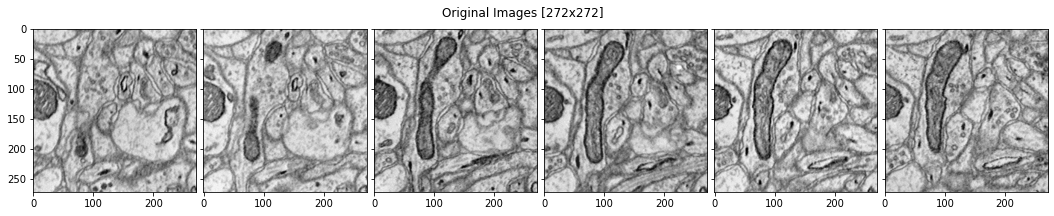

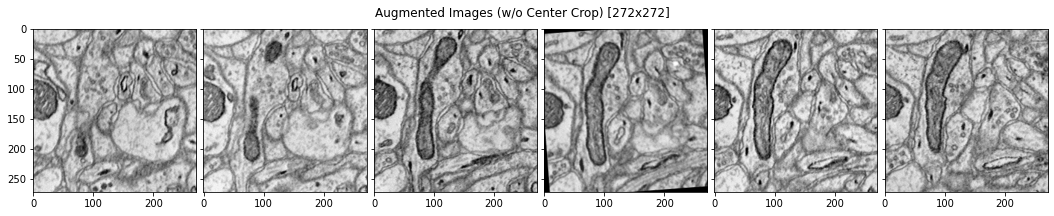

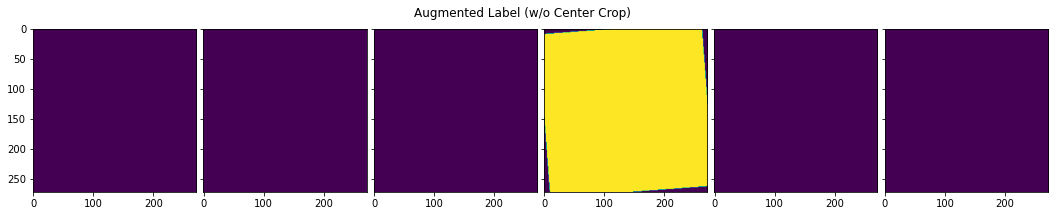

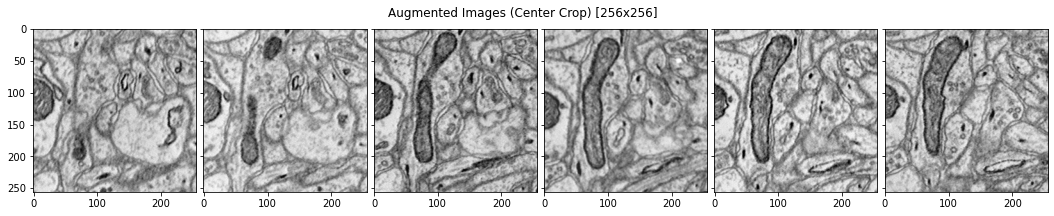

In [5]:
cfg.AUGMENTOR.MISALIGNMENT.ROTATE_RATIO = 1.0
cfg.AUGMENTOR.MISALIGNMENT.DISPLACEMENT = 16
test_augmentation(cfg, aug='MISALIGNMENT', show_label=True)

### CutBlur augmentation

Sample size required for the augmentor: [  6 256 256]


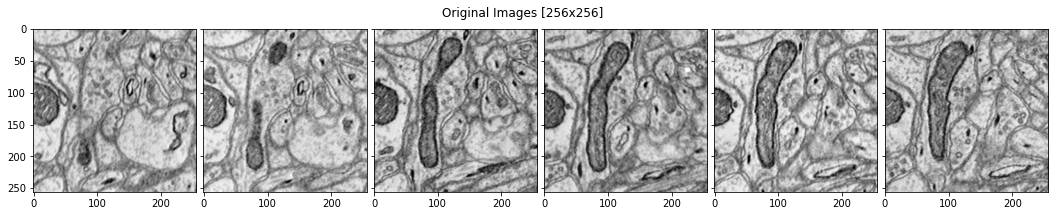

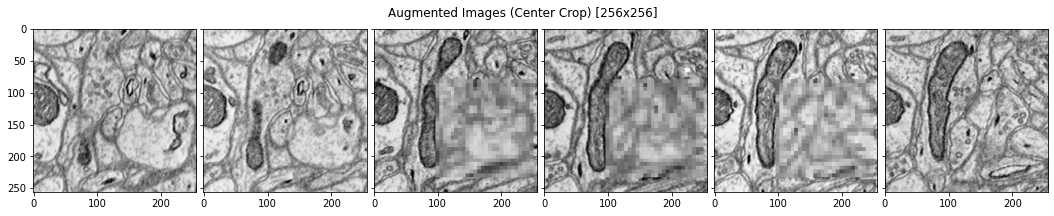

In [6]:
cfg.AUGMENTOR.CUTBLUR.P = 1.0
cfg.AUGMENTOR.CUTBLUR.DOWN_RATIO_MIN = 5.0
cfg.AUGMENTOR.CUTBLUR.LENGTH_RATIO = 0.6
test_augmentation(cfg, aug='CUTBLUR')